## tf keras transformers model

In [1]:
import pandas as pd
import numpy as np 
import pickle
import time
from datetime import datetime
import sys

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_addons as tfa


import matplotlib.pyplot as plt
import seaborn as sns

print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# from utils import * 
# del sys.modules['utils']
# from utils import * 

Version:  2.4.1
GPU is available


In [2]:
df = pd.read_csv("./data/df_slow.csv")
df.shape
summary = df["query_time_ns"]\
    .describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.00])
mask = (df["query_time_ns"]<summary["99%"])
sum(mask)
#%%
df = df[mask]
y = df['query_time_ns']
#%%
X = df['clean_query']
X.shape, y.shape

((15375,), (15375,))

In [3]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3)
xvalid, xtest, yvalid, ytest = train_test_split(xvalid, yvalid, test_size=0.3)
xtrain.shape, xvalid.shape, xtest.shape

((10762,), (3229,), (1384,))

In [4]:
m = ytrain.mean()
s = ytrain.std()

ytrain_transformed = (ytrain-m)/s
yvalid_transformed = (yvalid-m)/s

In [5]:
# Model constants.
max_features = 1000
embedding_dim = 32
sequence_length = 128
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)
vectorize_layer.adapt(xtrain.values)

Lets test our vectorize layer

In [6]:
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)

model_test = tf.keras.Model(text_input, x)
model_test.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 128)               0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


It seems it is working

In [7]:
model_test(tf.constant(["select"]))

<tf.Tensor: shape=(1, 128), dtype=int64, numpy=
array([[16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)>

Move onto model creation

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [9]:
checkpoint_filepath = "./tmp/checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_r_square',
                        mode='min',
                        save_best_only=True,
                        )   
def scheduler(epoch, lr):
    return lr * 0.8**epoch 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_r_square', 
                                patience=3,
                                restore_best_weights=True)
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
    checkpoint_callback,
    early_stopping,
    tb_callback,
]

In [10]:
tf.keras.backend.clear_session()

text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)

embedding_layer = TokenAndPositionEmbedding(sequence_length, max_features, embedding_dim)
x = embedding_layer(x)
transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs=text_input, outputs=outputs)


model.compile(loss="mean_squared_error", 
                optimizer="adam", 
                metrics=[tf.keras.metrics.RootMeanSquaredError(),
                         tf.keras.metrics.MeanAbsoluteError(),
                         tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 128)               0         
_________________________________________________________________
token_and_position_embedding (None, 128, 32)           36096     
_________________________________________________________________
transformer_block (Transform (None, 128, 32)           10656     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                660   

In [11]:
epochs = 30
batch_size = 32
history = model.fit(xtrain, ytrain_transformed, 
            validation_data=(xvalid, yvalid_transformed),
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=callbacks)

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
337/337 [==============================] - 20s 49ms/step - loss: 0.4849 - root_mean_squared_error: 0.6761 - mean_absolute_error: 0.4306 - r_square: 0.5241 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1765 - val_mean_absolute_error: 0.1071 - val_r_square: 0.9693
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000800000037997961.
337/337 [==============================] - 16s 47ms/step - loss: 0.0615 - root_mean_squared_error: 0.2479 - mean_absolute_error: 0.1513 - r_square: 0.9390 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1550 - val_mean_absolute_error: 0.0699 - val_r_square: 0.9763
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005120000243186951.
337/337 [==============================] - 16s 48ms/step - loss: 0.0480 - root_mean_squared_error: 0.2187 - mean_absolute_error: 0.1308 - r_square: 0.9515 - val_loss: 0.0215 -

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [13]:
def eval_model(model, x, y, m, s, data_type, prn = False):
    start = time.time()
    pred = model.predict(x)
    pred = (pred * s) + m
    pred_time = np.round((time.time() - start),4)
    if prn:
        print(f"{data_type} - Root mean squared error     : {(mean_squared_error(y, pred, squared=False)):.2f}")
        print(f"{data_type} - Mean absolute error         : {(mean_absolute_error(y, pred)):.2f}")
        print(f"{data_type} - Coefficient of determination: {(r2_score(y, pred)):.2f}")
        print(f"{data_type} - Time elapsed                : {pred_time}\n")
    return np.round(mean_squared_error(y, pred, squared=False),1), \
            np.round(mean_absolute_error(y, pred),1), \
            np.round(r2_score(y, pred),2), \
            pred_time

In [14]:
model_name = "keras_transformers"
model_path = "./models/" + model_name
model.save(model_path)

INFO:tensorflow:Assets written to: ./models/keras_transformers\assets


INFO:tensorflow:Assets written to: ./models/keras_transformers\assets


In [15]:
from pathlib import Path
model_directory = Path(model_path)
model_size = sum(f.stat().st_size for f in model_directory.glob('**/*') if f.is_file())

In [16]:
print(f"model size                         : {model_size}")
tr_rmse, tr_mae, tr_r2, tr_time_elapsed  = eval_model(model, xtrain, ytrain, m, s, data_type="Train", prn = True)
val_rmse, val_mae, val_r2, val_time_elapsed  = eval_model(model, xvalid, yvalid, m, s, data_type="Valid", prn = True)
test_rmse, test_mae, test_r2, test_time_elapsed  = eval_model(model, xtest, ytest, m, s, data_type="Test", prn = True)

model size                         : 1315385
Train - Root mean squared error     : 143379.75
Train - Mean absolute error         : 85192.11
Train - Coefficient of determination: 0.97
Train - Time elapsed                : 1.9141

Valid - Root mean squared error     : 137506.81
Valid - Mean absolute error         : 83456.31
Valid - Coefficient of determination: 0.97
Valid - Time elapsed                : 0.5218

Test - Root mean squared error     : 135340.62
Test - Mean absolute error         : 84909.85
Test - Coefficient of determination: 0.97
Test - Time elapsed                : 0.2535



In [17]:
df_performance = pd.read_csv("./data/df_performance.csv")
df_performance.set_index("Model", inplace=True)
df_performance

,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432.0,109958.6,38663.8,0.98,0.0016,143922.3,51397.7,0.97,0.0000,138415.1,52290.4,0.97,0.0000
svc_regr,7579.0,888415.7,422135.8,-0.29,0.0015,881327.0,428619.1,-0.31,0.0000,910742.5,446665.0,-0.31,0.0000
rand_for_reg,24770494.0,67211.8,20448.7,0.99,0.1519,134162.6,39441.2,0.97,0.0616,138995.7,42581.3,0.97,0.0275
ada_boost_reg,36763.0,219145.3,160038.5,0.92,0.0286,221945.0,161057.6,0.92,0.0103,231910.7,165048.4,0.91,0.0040
grd_boost_reg,120991.0,105024.1,39911.1,0.98,0.0120,130199.3,46705.4,0.97,0.0040,131216.3,48082.8,0.97,0.0040
xgb_reg,218927.0,70285.5,24723.6,0.99,0.0087,129252.8,38749.2,0.97,0.0041,132213.0,40272.0,0.97,0.0040
keras_conv1d,6487298.0,781090.3,594721.1,0.00,3.8083,776082.1,584514.0,0.00,1.1968,786705.2,597160.3,0.00,0.3920
keras_conv1d_y_transform,6488956.0,248101.8,164969.5,0.90,4.1894,248354.3,165562.9,0.90,0.9288,245817.8,165041.1,0.90,0.3614
keras_bi_dir_LSTM,10721678.0,173611.8,77624.4,0.95,13.6623,172175.1,77670.3,0.95,3.7964,156272.9,67821.0,0.96,1.6370


In [18]:
df_performance.loc[model_name,:] = [model_size, tr_rmse, tr_mae, tr_r2, tr_time_elapsed,\
                              val_rmse, val_mae, val_r2, val_time_elapsed,\
                             test_rmse, test_mae, test_r2, test_time_elapsed]
df_performance

,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432.0,109958.6,38663.8,0.98,0.0016,143922.3,51397.7,0.97,0.0000,138415.1,52290.4,0.97,0.0000
svc_regr,7579.0,888415.7,422135.8,-0.29,0.0015,881327.0,428619.1,-0.31,0.0000,910742.5,446665.0,-0.31,0.0000
rand_for_reg,24770494.0,67211.8,20448.7,0.99,0.1519,134162.6,39441.2,0.97,0.0616,138995.7,42581.3,0.97,0.0275
ada_boost_reg,36763.0,219145.3,160038.5,0.92,0.0286,221945.0,161057.6,0.92,0.0103,231910.7,165048.4,0.91,0.0040
grd_boost_reg,120991.0,105024.1,39911.1,0.98,0.0120,130199.3,46705.4,0.97,0.0040,131216.3,48082.8,0.97,0.0040
xgb_reg,218927.0,70285.5,24723.6,0.99,0.0087,129252.8,38749.2,0.97,0.0041,132213.0,40272.0,0.97,0.0040
keras_conv1d,6487298.0,781090.3,594721.1,0.00,3.8083,776082.1,584514.0,0.00,1.1968,786705.2,597160.3,0.00,0.3920
keras_conv1d_y_transform,6488956.0,248101.8,164969.5,0.90,4.1894,248354.3,165562.9,0.90,0.9288,245817.8,165041.1,0.90,0.3614
keras_bi_dir_LSTM,10721678.0,173611.8,77624.4,0.95,13.6623,172175.1,77670.3,0.95,3.7964,156272.9,67821.0,0.96,1.6370


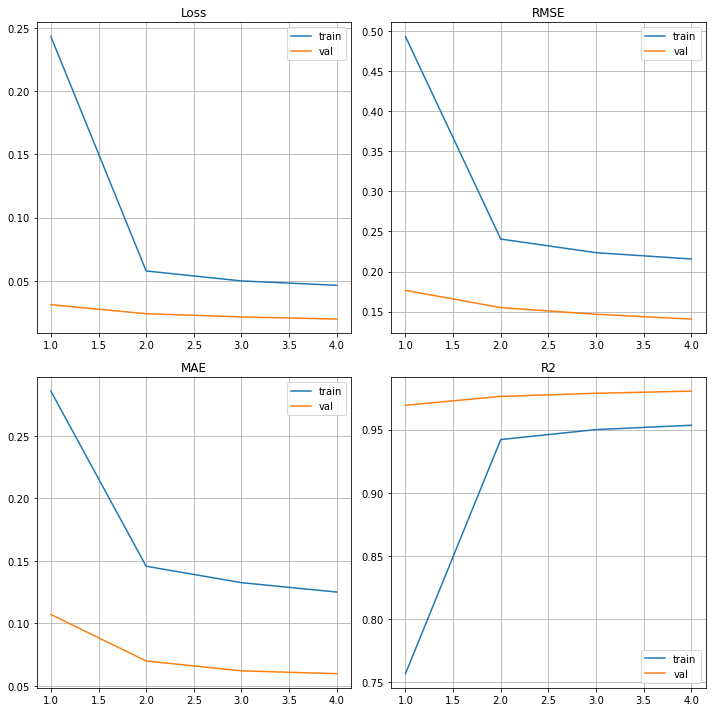

In [19]:
hist = pd.DataFrame(history.history)
x = hist.index+1
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(x, hist.loss, label="train")
plt.plot(x, hist.val_loss, label="val")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.plot(x, hist.root_mean_squared_error, label="train")
plt.plot(x, hist.val_root_mean_squared_error, label="val")
plt.title("RMSE")
plt.legend()
plt.grid(True)

plt.subplot(223)
plt.plot(x, hist.mean_absolute_error, label="train")
plt.plot(x, hist.val_mean_absolute_error, label="val")
plt.title("MAE")
plt.legend()
plt.grid(True)

plt.subplot(224)
plt.plot(x, hist.r_square, label="train")
plt.plot(x, hist.val_r_square, label="val")
plt.title("R2")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [20]:
df_performance.to_csv("./data/df_performance.csv",index_label='Model')

In [21]:
df_per = pd.read_csv("./data/df_performance.csv")
df_per.set_index("Model", inplace=True)
df_per

,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432.0,109958.6,38663.8,0.98,0.0016,143922.3,51397.7,0.97,0.0000,138415.1,52290.4,0.97,0.0000
svc_regr,7579.0,888415.7,422135.8,-0.29,0.0015,881327.0,428619.1,-0.31,0.0000,910742.5,446665.0,-0.31,0.0000
rand_for_reg,24770494.0,67211.8,20448.7,0.99,0.1519,134162.6,39441.2,0.97,0.0616,138995.7,42581.3,0.97,0.0275
ada_boost_reg,36763.0,219145.3,160038.5,0.92,0.0286,221945.0,161057.6,0.92,0.0103,231910.7,165048.4,0.91,0.0040
grd_boost_reg,120991.0,105024.1,39911.1,0.98,0.0120,130199.3,46705.4,0.97,0.0040,131216.3,48082.8,0.97,0.0040
xgb_reg,218927.0,70285.5,24723.6,0.99,0.0087,129252.8,38749.2,0.97,0.0041,132213.0,40272.0,0.97,0.0040
keras_conv1d,6487298.0,781090.3,594721.1,0.00,3.8083,776082.1,584514.0,0.00,1.1968,786705.2,597160.3,0.00,0.3920
keras_conv1d_y_transform,6488956.0,248101.8,164969.5,0.90,4.1894,248354.3,165562.9,0.90,0.9288,245817.8,165041.1,0.90,0.3614
keras_bi_dir_LSTM,10721678.0,173611.8,77624.4,0.95,13.6623,172175.1,77670.3,0.95,3.7964,156272.9,67821.0,0.96,1.6370
